In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import splat
import numpy
import astropy.units as u
from astropy import constants as const 
import copy
from scipy.integrate import trapz        # for numerical integration
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import pandas as pd
%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
DATA_FOLDER='/users/caganze/research/J1624/data/'

In [3]:
#nearby M dwarfs
df=pd.read_excel(DATA_FOLDER+'UCD_lateM_dwarf_precision_RV_20pc_thin_disk_population.xlsx')

In [4]:
def proper_motion_to_uvw(coord, mu_alpha, mu_delta, rv, pi):
    #coord is a skycoord object
    #v is the velocity vector
    k= 4.74057
    v=np.array([rv, k*mu_alpha/pi, k*mu_delta/pi])
    a, b= coord.icrs.ra.radian, coord.icrs.dec.radian
    T=np.matrix([[-0.06699, -0.87276, -0.48354],
    [0.49273, -0.45035, 0.74458],
    [-0.86760, -0.18837,0.46020]])

    A=np.matrix([[np.cos(a)*np.cos(b), -np.sin(a), -np.cos(a)*np.sin(b)],
       [np.sin(a)*np.cos(b) ,np.cos(a), -np.sin(a)*np.cos(b)],
       [np.sin(b), 0,np.cos(b)]])
    B= T @ A
    
    return B@v



In [5]:
#double-check for trappist one
trap= SkyCoord(ra=346.6250957*u.deg, dec=-5.0428081*u.deg,  
               radial_velocity=-51*u.km/u.s,  pm_ra_cosdec=922.0*u.mas/u.yr,
               pm_dec=-471.9*u.mas/u.yr, distance=12.49*u.pc)
#proper_motion_to_uvw(trap, 922.0*1e-3, 471.9*1e-3, -51.688, 80.09*1e-3)

from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)


In [6]:
trap.galactic.velocity

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (-43.70086526, -65.90881228, 10.3934991)>

In [7]:
coord=SkyCoord(ra=246.0684208*u.deg, dec=-32.2037824*u.deg,
               radial_velocity=0.3*u.km/u.s, pm_ra_cosdec=-25.81*u.mas/u.yr, 
               pm_dec=-185*u.mas/u.yr, distance=16.7*u.pc)
#rv_unc=0.13

#rvs=np.random.normal(0.3, 0.13, 1000)

#ms=np.array([proper_motion_to_uvw(coord, x, -25.81/100, -185.78) for x in rvs])

In [8]:
vx, vy, vz=coord.galactic.velocity.d_x, coord.galactic.velocity.d_y, coord.galactic.velocity.d_z

In [9]:
#u

In [10]:
#m, mer=np.nanmedian(ms, axis=0), np.nanstd(ms, axis=0)


In [11]:
#m=m.flatten()
#mer=mer.flatten()

In [12]:
#kiman catalog
#kiman catalog
data=pd.read_hdf(DATA_FOLDER+'/merged_Mdwarfs.h5', key='merged')

In [13]:
mask=np.logical_and.reduce([data.photometric_sample_subg !=0,
                            data.photometric_sample_subred !=0,
                            data.GOODPHOT_SDSS ==1, 
                            data.GOODMATCH==1,
                            abs(data.parallax_error/data.parallax)<0.2,
                           data.SPT_x <8.])

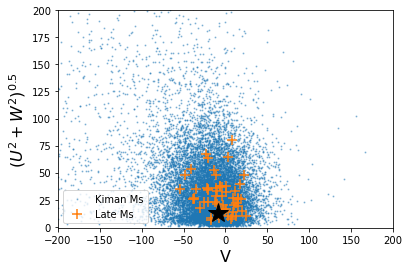

In [14]:
fig, ax=plt.subplots()

plt.scatter(data.V[mask], ((data.U**2+data.W)**0.5)[mask], s=1, alpha=0.4, label='Kiman Ms')
#plt.scatter(data.VZ, (data.VX**2+data.VY)**0.5, s=1, alpha=0.4, label='Kiman Ms')
plt.scatter(df.V, (df.U**2+df.W**2)**0.5, s=100, marker='+', label='Late Ms')
ax.errorbar(vz.value, (vx.value**2+ vy.value**2)**0.5, ms=20,  fmt='*', color='k')
plt.xlim([-200, 200])
plt.ylim([-1, 200])
plt.xlabel('V', fontsize=16)
plt.ylabel(r'$(U^2+ W^2)^{0.5}$', fontsize=16)
plt.legend(loc='lower left')


In [15]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1 
gcs=Vizier.get_catalogs('J/A+A/530/A138')


In [67]:
metal=(0.29, 0.07)

In [40]:

gcs_df=gcs[0].to_pandas()

In [74]:
gcs_bools=gcs_df['__Fe_H_'].between(metal[0]-3*metal[-1], metal[0]+3*metal[-1] )

In [79]:
metal[0]-3*metal[-1],

(0.07999999999999996,)

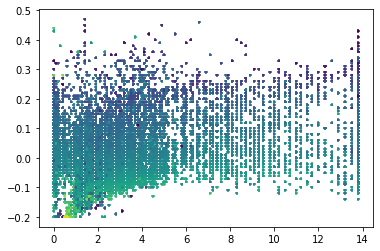

In [65]:
fig, ax=plt.subplots()
plt.scatter( gcs_df['ageMLP'],gcs_df['__a_Fe_'], c=gcs_df['__Fe_H_'], s=10, marker='+')

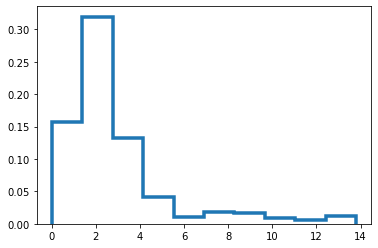

In [77]:
fig, ax=plt.subplots()
#h=ax.hist(gcs[0]['ageMLP'], histtype='step',  lw=3.5, density=True)
h=ax.hist(gcs_df['ageMLP'][gcs_bools],  histtype='step',  lw=3.5, density=True, 
         label='GCS ')
plt.xlabel('')

In [76]:
#plt.plot(gcs[0]['__Fe_H_'], gcs[0]['age'])

In [16]:
#gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

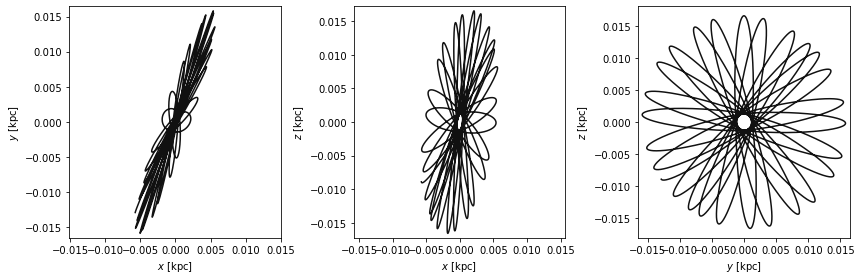

In [17]:
#m[1]
milky_way = gp.MilkyWayPotential()
H = gp.Hamiltonian(milky_way)
w0 = gd.PhaseSpacePosition(coord.cartesian)
orbits=H.integrate_orbit(w0,t=np.logspace(0, 4,10000)*u.Myr, cython_if_possible=True)
fig = orbits.plot(color='#111111')


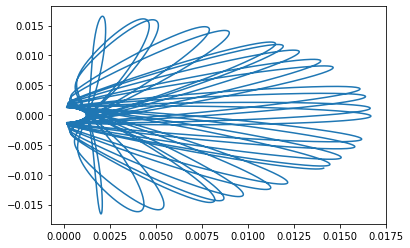

In [18]:
fig, ax=plt.subplots()
rs=(orbits.cartesian.x**2+orbits.cartesian.y**2)**0.5
plt.plot(rs, orbits.cartesian.z)

In [19]:
mask2= np.logical_and(mask, data['FEH_ERR'] <0.2)

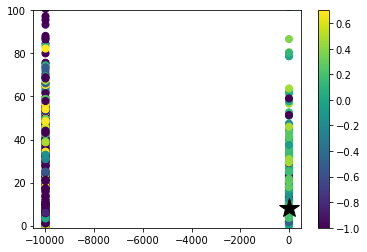

In [20]:
fig, ax=plt.subplots()
#ax.errorbar( data['FEH'][mask2], np.abs(data.W[mask2]), xerr=data['FEH_ERR'][mask2], fmt='o',
#            ms=1., alpha=0.2)
cb=ax.scatter( data['FEH'][mask2], np.abs(data.W[mask2]), c=data['HALPHA'][mask2],
            s=50., vmin=-1, vmax=0.7)
ax.errorbar(0.29, abs(vz.value), xerr= 0.07, ms=20, fmt='*', c='k')
plt.ylim([-1, 100])
plt.colorbar(cb)
#plt.ylim([-1, 1])


In [21]:
vx

<Quantity -0.74480971 km / s>

In [22]:
vy

<Quantity -12.22468683 km / s>

In [23]:
vz

<Quantity -8.29236341 km / s>